# Modeling Workflow Example - Greenplum Database

----

Greenplum Database features used

* Apache MADlib - http://madlib.apache.org/
* Procedural language extension to Python - https://gpdb.docs.pivotal.io/530/ref_guide/extensions/pl_python.html

----

Example uses Online Retail Data found at UCI Machine Learning Repository

http://archive.ics.uci.edu/ml/datasets/online+retail

----

## Index

### Setup 

* <a href="#dependencies">Dependencies</a>
* <a href="#package_options">Package Options</a>
* <a href="#database_connection">Database Connection</a>
    
    
### Data Loading

* <a href="#download_data">Download Data</a>
* <a href="#import_data">Import Data</a>
* <a href="#cleanup_data">Cleanup Data</a>


### Data Audit

* <a href="#summary_statistics">Summary Statistics</a>
* <a href="#missing_data">Missing Data</a>


### Data Exploration

* <a href="#de_daysbetweenvisits">Days Between Visits</a>
* <a href="#de_cancellation">Cancellation</a>
* <a href="#de_invoiceno">Invoice No</a>
* <a href="#de_stockcode">Stockcode</a>
* <a href="#de_description">Description</a>
* <a href="#de_quantity">Quantity</a>
* <a href="#de_invoicedate">Invoice Date</a>
* <a href="#de_unitprice">Unit Price</a>
* <a href="#de_customerid">Customer ID</a>
* <a href="#de_country">Country</a>


### Feature Engineering

* <a href="#outlier_cust_ids">Create List Of Outlier Customer IDs</a>
* <a href="#model_input_table">Build Model Input table</a>

**Current invoice**
* <a href="#fv_cancellation_exists">Cancellation Exists On Invoice (Yes / No)</a>
* <a href="#fv_total_num_ind_items">Total Number Of Individual Items</a>
* <a href="#fv_total_num_unq_items">Total number Of Unique Items</a>
* <a href="#fv_total_dollar_amount">Total Dollar Amount Of Invoice</a>
* <a href="#fv_min_item_amount">Minimum Dollar Amount Of Any One Item On Invoice</a>
* <a href="#fv_max_item_amount">Maximum Dollar Amount Of Any One Item On Invoice</a>
* <a href="#fv_country">Invoice Country 'United Kingdom', 'Germany', 'France' or Other</a>

**Historical invoice**
* <a href="#fv_cancellation_exists_lst_days">Cancellation Exists On Invoice In Last t Days (Yes / No)</a>
* <a href="#fv_total_invoices_lst_days">Total Number Of Invoices Over The Last t Days</a>
* <a href="#fv_total_dollar_amount_lst_days">Total Dollar Amount Spent Over Last t Days (Does Not Include  Cancellations or Negative Amounts)</a>

### Model Development

* <a href="#train_vali_split">Training & Validation Sample Split</a>

**Random Forest**
* <a href="#rf_train_model">Train model</a>
* <a href="#rf_variable_importance">Variable Importance</a>
* <a href="#rf_score_out_of_sample">Score Validation Data</a>
* <a href="#rf_confusion_matrix">Confusion Matrix</a>
* <a href="#rf_auc">Area Under ROC Curve</a>
* <a href="#rf_roc">Receiver Operating Characteristic Graph (ROC Curve)</a>

### Functions

* <a href="#bar_plot">bar_plot()</a>

----


## Setup

<a id="dependencies"></a>

In [1]:
# dependencies
import psycopg2
import pandas as pd
import xlrd
import urllib
import re
import seaborn as sns
#from matplotlib import pyplot as plt

import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown

<a id="package_options"></a>

In [2]:
# package options
%matplotlib inline
%pylab inline

pylab.rcParams['figure.figsize'] = (12, 8)
    
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_colwidth', -1)

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000

sns.set(style="darkgrid")

Populating the interactive namespace from numpy and matplotlib


<a id="database_connection"></a>

In [3]:
# init to default values
database_host = 'gpdb'
database_databasename = 'gpadmin'
database_username = 'gpadmin'
database_password = 'pivotal'

# interpret string as markdown
def printmd(string):
    display(Markdown(string))
    
# forms
message = "### Connection Details \n ------"
printmd(message)
    
printmd("**Host:**")
inputHost = widgets.Text()
display(inputHost)

printmd("**Database Name:**")
inputDatabaseName = widgets.Text()
display(inputDatabaseName)

printmd("**Username:**")
inputUsername = widgets.Text()
display(inputUsername)

printmd("**Password:**")
inputPassword = widgets.Text()
display(inputPassword)

printmd("*Leave blank for default values*")


def db_connect():
    global conn, cur
    try:
        conn = psycopg2.connect("host='{}' dbname='{}' user='{}' password='{}'".format(database_host,database_databasename,database_username,database_password))
        cur = conn.cursor()
        conn.autocommit = True
        message = "<span style='color:green'>**Connection successful!**</span>"
        printmd(message)
    except:
        message = "<span style='color:red'>**ERROR: Unable to connect to the database**</span>"
        printmd(message)
    
def on_button_click(b):
    
    global database_host, database_databasename, database_username, database_password
    
    clear_output()
    
    message = "### Connection Details \n ------"
    printmd(message)
    
    if inputHost.value == "":
        message = "**Host:** {} (default)".format(database_host)
        printmd(message)
    else:
        database_host = inputHost.value
        message = "**Host:** {}".format(database_host)
        printmd(message)
  
    if inputDatabaseName.value == "":
        message = "**Database name:** {} (default)".format(database_databasename)
        printmd(message)
    else:
        database_databasename = inputDatabaseName.value
        message = "**Database name:** {}".format(database_databasename)
        printmd(message)
        
    if inputUsername.value == "":
        message = "**Username:** {} (default)".format(database_username)
        printmd(message)
    else:
        database_username = inputUsername.value
        message = "**Username:** {}".format(database_username)
        printmd(message)
        
    if inputPassword.value == "":
        message = "**Password:** {} (default)".format(database_password)
        printmd(message)
    else:
        database_password = inputPassword.value
        message = "**Password:** ###########"
        printmd(message)
    
    printmd("------")
    db_connect()
        
button = widgets.Button(description="Connect")
display(button)
button.on_click(on_button_click)

### Connection Details 
 ------

**Host:** gpdb (default)

**Database name:** gpadmin (default)

**Username:** gpadmin (default)

**Password:** pivotal (default)

------

<span style='color:green'>**Connection successful!**</span>

----
## Data Loading

In [4]:
# download xlsx file
dls = "http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
urllib.urlretrieve(dls, "OnlineRetail.xlsx")

('OnlineRetail.xlsx', <httplib.HTTPMessage instance at 0x7f64e0419bd8>)

In [5]:
# create table shell in gpdb
query = """
    DROP TABLE IF EXISTS public.online_retail_data
"""
cur.execute(query)

ddl = """
    CREATE TABLE public.online_retail_data (
        invoiceno text
       ,stockcode text
       ,description text
       ,quantity float
       ,invoicedate timestamp
       ,unitprice float
       ,customerid text
       ,country text
    ) DISTRIBUTED BY (invoiceno);
"""
cur.execute(ddl)

In [6]:
# convert xlsx timestamp to greenplum timstamp
def xlsx_timestamp_to_gpdb(dt):
    d = xlrd.xldate_as_tuple(dt,0)
    return "{}-{:02d}-{:02d} {:02d}:{:02d}:{:02d}".format(d[0],d[1],d[2],d[3],d[4],d[5])

In [7]:
# function to create a string representation of record
def create_row(types, record):
    rowValues = '';
        
    for i in range(0,len(types)):
        
        # remove non-ascii characters (replaces with whitespace)
        # Example:
        # Dotcomgiftshop Gift Voucher £40.00
        # Dotcomgiftshop Gift Voucher  40.00
        #if is_ascii(record[i]) == False:  
        #    record[i] = re.sub(r'[^\x00-\x7F]+',' ', record[i])
        
        if record[i] == '':
            rowValues = rowValues + ", null"
        else:
            # add single quotes around text fields
            if types[i] in ['text','varchar']:
                if isinstance(record[i], float) or isinstance(record[i], int):
                     rowValues = rowValues + ",$r${}$r$".format(str(record[i]))
                else:
                    rowValues = rowValues + ",$r${}$r$".format(record[i].encode('utf-8'))
            elif types[i] == 'timestamp':
                rowValues = rowValues + ",'{}'".format(xlsx_timestamp_to_gpdb(record[i])) 
            else:
                rowValues = rowValues + ",{}".format(record[i])
            
    return ",({})".format(rowValues[1:])

In [8]:
# load xlsx file into gpdb
def load_xlsx_file(xlsxFilename, batchSize):
    
    # open workbook
    workbook = xlrd.open_workbook(xlsxFilename)
    sheet = workbook.sheet_by_index(0)
    
    prep_data = ''
    
    # iterate through rows in sheet 
    for r in range(1,sheet.nrows):
        
        rec = sheet.row_values(r)
        
        colTypes = ["text","text","text","float","timestamp","float","text","text"]
        
        prep_data = prep_data + create_row(colTypes,rec)
        
        # batch load N records at a time
        if (r % batchSize) == 0:  
            query = """
                INSERT INTO public.online_retail_data VALUES {}
            """.format(prep_data[1:])
            cur.execute(query)
            prep_data = ''
    
    # load any remaining records
    if prep_data != '':
        query = """
              INSERT INTO public.online_retail_data VALUES {}
        """.format(prep_data[1:])
        cur.execute(query)       

    # clean up
    workbook.release_resources()
    del workbook

In [ ]:
load_xlsx_file("OnlineRetail.xlsx", 1000)

In [9]:
# parse cancellation field out of invoiceno
query = """
    DROP TABLE IF EXISTS public.online_retail_data_2;
    CREATE TABLE public.online_retail_data_2 AS
    SELECT CASE WHEN substring(invoiceno,1,1) = 'C' THEN 1 ELSE 0 END AS cancellation
          ,CASE WHEN substring(invoiceno,1,1) = 'C' THEN substring(invoiceno,2,6)
                ELSE substring(invoiceno,1,6)
           END AS invoiceno
          ,stockcode 
          ,description 
          ,quantity 
          ,invoicedate
          ,unitprice 
          ,customerid 
          ,country 
    FROM public.online_retail_data
    DISTRIBUTED BY (invoiceno);
    DROP TABLE public.online_retail_data;
    ALTER TABLE public.online_retail_data_2 RENAME TO online_retail_data;
"""

cur.execute(query)

In [10]:
query = """
    SELECT cancellation
          ,invoiceno
          ,stockcode 
          ,description 
          ,quantity 
          ,invoicedate
          ,unitprice 
          ,customerid 
          ,country 
    FROM public.online_retail_data
    LIMIT 10
"""
cur.execute(query)
colnames = [desc[0] for desc in cur.description]
pd.DataFrame(cur.fetchall(), columns=colnames)

,cancellation,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,0,536366,22633.0,HAND WARMER UNION JACK,6.0,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
1,0,536366,22632.0,HAND WARMER RED POLKA DOT,6.0,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
2,0,536368,22960.0,JAM MAKING SET WITH JARS,6.0,2010-12-01 08:34:00,4.25,13047.0,United Kingdom
3,0,536368,22913.0,RED COAT RACK PARIS FASHION,3.0,2010-12-01 08:34:00,4.95,13047.0,United Kingdom
4,0,536368,22912.0,YELLOW COAT RACK PARIS FASHION,3.0,2010-12-01 08:34:00,4.95,13047.0,United Kingdom
5,0,536368,22914.0,BLUE COAT RACK PARIS FASHION,3.0,2010-12-01 08:34:00,4.95,13047.0,United Kingdom
6,0,536371,22086.0,PAPER CHAIN KIT 50'S CHRISTMAS,80.0,2010-12-01 09:00:00,2.55,13748.0,United Kingdom
7,0,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 09:02:00,2.55,17850.0,United Kingdom
8,0,536373,71053.0,WHITE METAL LANTERN,6.0,2010-12-01 09:02:00,3.39,17850.0,United Kingdom
9,0,536373,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 09:02:00,2.75,17850.0,United Kingdom


In [11]:
query = """
    SELECT count(*)
    FROM public.online_retail_data
"""
cur.execute(query)
pd.DataFrame(cur.fetchall())

,0
0,541909


----
## Data Audit

<a id="summary_statistics"></a>
Summary Statistics

In [13]:
# drop existing table & run madlib summary stats function
query = """
    DROP TABLE IF EXISTS public.online_retail_summary;
    SELECT madlib.summary('public.online_retail_data','public.online_retail_summary');
"""
cur.execute(query)

# grab results from gpdb
query = """
    SELECT * FROM public.online_retail_summary;
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
or_summary = pd.DataFrame(cur.fetchall(), columns=colnames)

In [14]:
or_summary

,group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,mean,variance,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
0,None,None,cancellation,1,int4,541909,2,0,NaN,0.000000,NaN,0.017139,0.016846,0.00,1.0,0.00,0.00,0.00,"[0, 0, 1, 1]","[532621, 532621, 9288, 9288]"
1,None,None,invoiceno,2,text,541909,26376,0,0.0,0.000000,0.000000,NaN,NaN,6.00,6.0,NaN,NaN,NaN,"[573585, 580729, 579777, 581219, 581492, 580730, 580367, 580983, 558475, 576618]","[1421, 1203, 1095, 1070, 1029, 979, 969, 943, 940, 939]"
2,None,None,stockcode,3,text,541909,4070,0,0.0,0.000000,0.000000,NaN,NaN,1.00,12.0,NaN,NaN,NaN,"[85123A, 85123A, 22423.0, 22423.0, 85099B, 85099B, 47566.0, 47566.0, 20725.0, 20725.0]","[2324, 2324, 2203, 2203, 2166, 2166, 1808, 1808, 1793, 1793]"
3,None,None,description,4,text,541909,4223,1454,55.0,0.002683,0.000101,NaN,NaN,1.00,35.0,NaN,NaN,NaN,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE HANGING HEART T-LIGHT HOLDER, REGENCY CAKESTAND 3 TIER, REGENCY CAKESTAND 3 TIER, JUMBO BAG RED RETROSPOT, JUMBO BAG RED RETROSPOT, PARTY BUNTING, PARTY BUNTING, LUNCH BAG RED RETROSPOT, LUNCH BAG RED RETROSPOT]","[2449, 2449, 2243, 2243, 2208, 2208, 1737, 1737, 1649, 1649]"
4,None,None,quantity,5,float8,541909,722,0,NaN,0.000000,NaN,9.552250,47559.391409,-80995.00,80995.0,1.00,3.00,10.00,"[1, 1, 2, 2, 12, 12, 6, 6, 4, 4]","[148227, 148227, 81829, 81829, 61063, 61063, 40868, 40868, 38484, 38484]"
5,None,None,invoicedate,6,timestamp,541909,23414,0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[2011-10-31 14:41:00, 2011-12-08 09:28:00, 2011-12-05 17:28:00, 2011-06-29 15:58:00, 2011-12-09 10:03:00, 2011-12-05 17:24:00, 2011-12-08 09:20:00, 2011-11-24 09:26:00, 2011-11-25 16:14:00, 2011-12-08 16:30:00]","[1314, 1092, 1050, 1045, 1042, 1038, 1037, 1028, 950, 932]"
6,None,None,unitprice,7,float8,541909,1630,0,NaN,0.000000,NaN,4.611114,9362.469164,-11062.06,38970.0,1.25,2.08,4.13,"[1.25, 1.25, 1.65, 1.65, 0.85, 0.85, 2.95, 2.95, 0.42, 0.42]","[50496, 50496, 38182, 38182, 28497, 28497, 27768, 27768, 24533, 24533]"
7,None,None,customerid,8,text,541909,4372,135080,0.0,0.249267,0.000000,NaN,NaN,7.00,7.0,NaN,NaN,NaN,"[17841.0, 17841.0, 14911.0, 14911.0, 14096.0, 14096.0, 12748.0, 12748.0, 14606.0, 14606.0]","[7983, 7983, 5903, 5903, 5192, 5192, 4642, 4642, 2841, 2841]"
8,None,None,country,9,text,541909,38,0,0.0,0.000000,0.000000,NaN,NaN,3.00,20.0,NaN,NaN,NaN,"[United Kingdom, United Kingdom, Germany, Germany, France, France, EIRE, EIRE, Spain, Spain]","[495478, 495478, 9495, 9495, 8557, 8557, 8196, 8196, 2533, 2533]"


<a id="missing_data"></a>

**Missing data**

<a id="bar_plot"></a>

In [15]:
def bar_plot(data,title,x,xLabel,y,yLabel,color=None,xAxisRotation=90):

    # Bar plot
    pylab.rcParams['figure.figsize'] = (12, 8)
    seq_col_brew = sns.color_palette("Blues_r", 1)
    sns.color_palette(seq_col_brew)
    if color != None:
        plt = sns.barplot(x=x, y=y, data=data, color=color)
    else:
        plt = sns.barplot(x=x, y=y, data=data)
        
    # titles
    plt.set_title(title,fontsize=30)
    plt.set_xlabel(xLabel,fontsize=16)
    plt.set_ylabel(yLabel,fontsize=16)
    
    # rotate x axis labels
    for item in plt.get_xticklabels():
        item.set_rotation(xAxisRotation)

    # remove scientific notation
    plt.ticklabel_format(style='plain', axis='y')

    # add 1000s commas
    #plt.get_yaxis().set_major_formatter(
    #    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

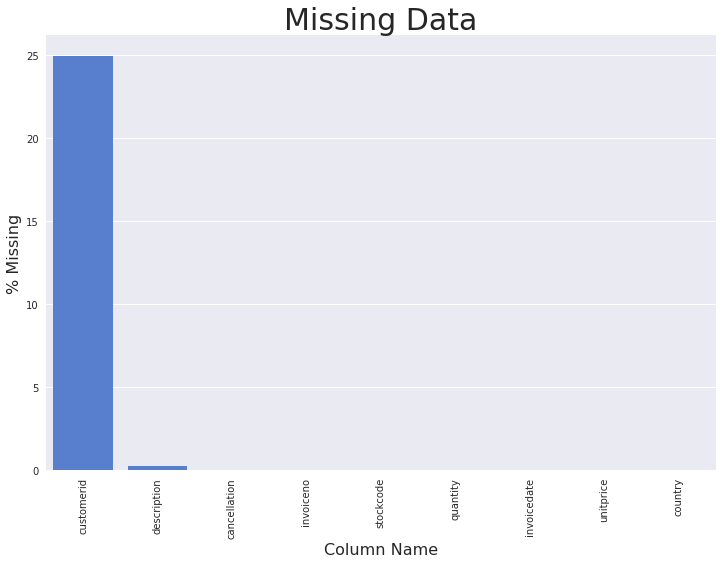

In [16]:
missing_counts = or_summary.sort_values('missing_values',ascending=False)
missing_counts['perc_missing'] = missing_counts['fraction_missing'] * 100.0
bar_plot(missing_counts,"Missing Data","target_column","Column Name","perc_missing","% Missing", "#4378E2")

**Timeseries view of data**

In [17]:
query = """
    SELECT min(invoicedate) AS min_invoicedate
          ,max(invoicedate) AS max_invoicedate
    FROM public.online_retail_data
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
pd.DataFrame(cur.fetchall(), columns=colnames)

,min_invoicedate,max_invoicedate
0,2010-12-01 08:26:00,2011-12-09 12:50:00


In [18]:
# Are missing record random across time? or start occuring at one point in time?
query = """
    SELECT invoicedate AS invoicedate
          ,coalesce(record_count,0) AS record_count
          ,coalesce(missing_count,0) AS missing_count
          ,coalesce((missing_count / record_count::float) * 100,0) as missing_perc
    FROM (
        SELECT invoicedate::date as invoicedate
              ,count(*) AS record_count
              ,count(CASE WHEN customerid ISNULL or customerid = '' THEN 1 ELSE null END) AS missing_count
        FROM public.online_retail_data
        GROUP BY 1
    ) l RIGHT JOIN (
        SELECT generate_series
                    ( min_invoicedate
                    , max_invoicedate
                    , '1 day'::interval) AS invoicedate
        FROM (
            SELECT min(invoicedate::date) AS min_invoicedate
                  ,max(invoicedate::date) AS max_invoicedate
            FROM public.online_retail_data
        ) inner_r
    ) r USING (invoicedate)
    ORDER BY invoicedate
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
missingCustomerID = pd.DataFrame(cur.fetchall(), columns=colnames)

missingCustomerID.head()

,invoicedate,record_count,missing_count,missing_perc
0,2010-12-01 00:00:00+00:00,3108,1140,36.679537
1,2010-12-02 00:00:00+00:00,2109,65,3.082029
2,2010-12-03 00:00:00+00:00,2202,1085,49.273388
3,2010-12-04 00:00:00+00:00,0,0,0.000000
4,2010-12-05 00:00:00+00:00,2725,1,0.036697


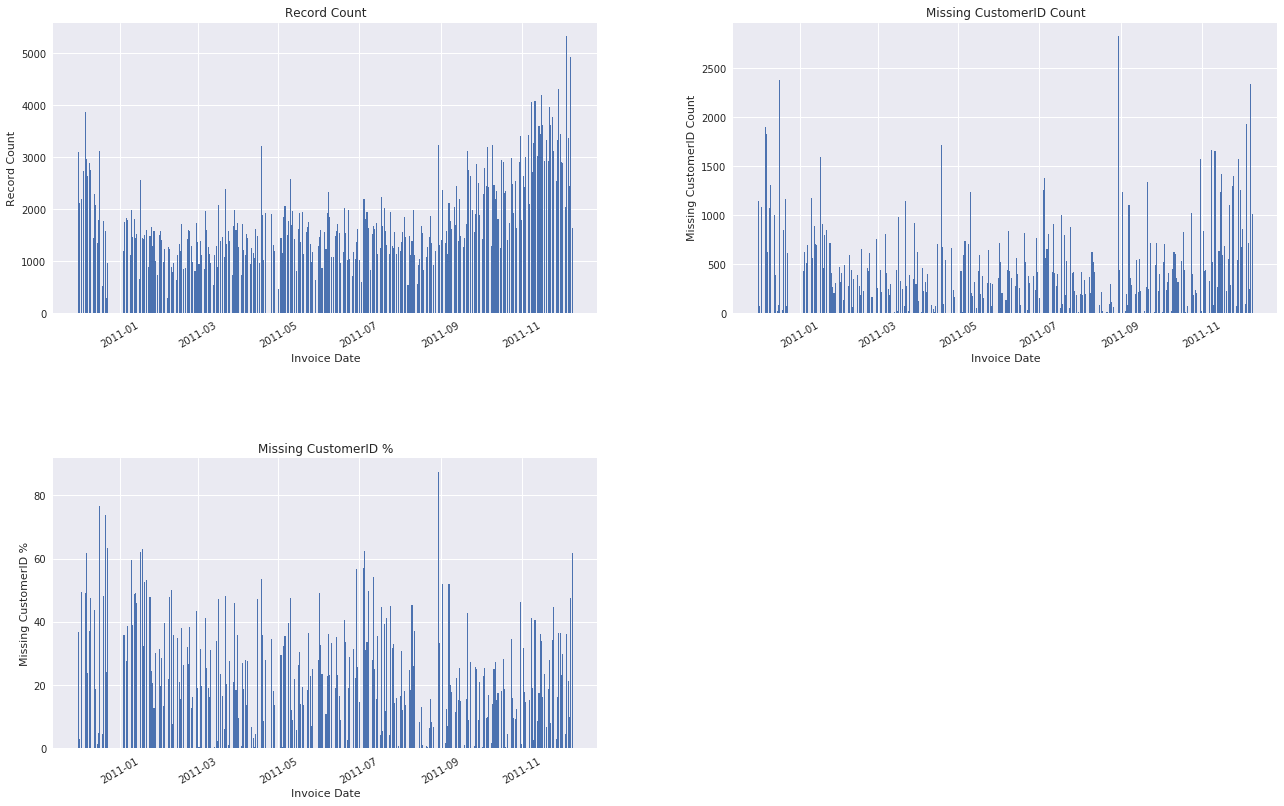

In [19]:
# set canvas size
pylab.rcParams['figure.figsize'] = (20, 12)

# top left graph
plt.figure(1)
p1 = plt.subplot(221)
p1.set_title("Record Count")
plt.ylabel("Record Count")
plt.xlabel("Invoice Date")
p1.bar(missingCustomerID['invoicedate'], missingCustomerID['record_count'])

for item in plt.gca().get_xticklabels():
    item.set_rotation(30)
        
# top right graph
p2 = plt.subplot(222)
p2.set_title("Missing CustomerID Count")
plt.ylabel("Missing CustomerID Count")
plt.xlabel("Invoice Date")
p2.bar(missingCustomerID['invoicedate'], missingCustomerID['missing_count'])

for item in plt.gca().get_xticklabels():
    item.set_rotation(30)
    
# bottom left graph
p3 = plt.subplot(223)
p3.set_title("Missing CustomerID %")
plt.ylabel("Missing CustomerID %")
plt.xlabel("Invoice Date")
plt.bar(missingCustomerID['invoicedate'], missingCustomerID['missing_perc'])

for item in plt.gca().get_xticklabels():
    item.set_rotation(30)
    
# adjust subplot positioning
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.50, wspace=0.25)

# show plot
plt.show()

----
## Data Exploration

<a id="de_daysbetweenvisits"></a>
#### Days Between Visits

In [4]:
# how many invoices and shopping days does each customer have
query = """
    SELECT customerid
          ,count(distinct invoiceno) AS dist_invoiceno
          ,count(distinct invoicedate::date) AS dist_invoicedate
    FROM public.online_retail_data
    GROUP BY 1
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)

In [5]:
# calculate summary stats of table
df.describe()

,dist_invoiceno,dist_invoicedate
count,4373.000000,4373.000000
mean,5.922250,4.475875
std,56.768981,7.843983
min,1.000000,1.000000
25%,1.000000,1.000000
50%,3.000000,2.000000
75%,5.000000,5.000000
max,3708.000000,277.000000


In [6]:
# number customers with more than one invoice
len(df.query('dist_invoiceno > 1')['customerid'].unique())

3060

In [7]:
# number customers with more than one shopping day
len(df.query('dist_invoicedate > 1')['customerid'].unique())

2992

In [8]:
# number of invoices that are on the same day
query = """
    SELECT dist_invoiceno
          ,count(distinct customerid) AS cnt
    FROM (
        SELECT customerid
              ,invoicedate::date AS invoice_day
              ,count(distinct invoiceno) AS dist_invoiceno
        FROM public.online_retail_data
        WHERE customerid NOTNULL
        GROUP BY 1, 2
    ) foo
    GROUP BY 1
    ORDER BY 1
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)
df

,dist_invoiceno,cnt
0,1,4292
1,2,907
2,3,202
3,4,45
4,5,12
5,6,10
6,7,5
7,8,1
8,10,2
9,12,1


In [10]:
# distribution of # of shopping days
sns.distplot(df.query('dist_invoiceno <= 20')['dist_invoicedate'])

KeyError: 'dist_invoicedate'

In [441]:
# days between invoices
query = """
    SELECT *
    FROM (
        SELECT customerid
              ,invoicedate
              ,date_part('day', lead(invoicedate::date,1,null) OVER (PARTITION BY customerid ORDER BY invoicedate) 
                  - invoicedate::date) AS invoicedate_delta
        FROM (
            SELECT customerid
                  ,invoicedate::date AS invoicedate
            FROM public.online_retail_data
            GROUP BY 1,2
        ) foo
    ) bar
    WHERE invoicedate_delta NOTNULL
    AND customerid NOT IN ('{}')
    AND customerid NOTNULL
    ORDER BY 1,2
""".format("','".join(customerIDExcludeList))
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)

In [444]:
# # in next 14 days
print len(df.query('invoicedate_delta <= 14'))
print len(df.query('invoicedate_delta > 14'))

3517
7991


In [451]:
query = """
    SELECT *
    FROM (
        SELECT customerid
              ,invoicedate
              ,date_part('day', lead(invoicedate::date,1,null) OVER (PARTITION BY customerid ORDER BY invoicedate) 
                  - invoicedate::date) AS invoicedate_delta
        FROM (
            SELECT customerid
                  ,invoicedate::date AS invoicedate
            FROM public.online_retail_data
            GROUP BY 1,2
        ) foo
    ) bar
    WHERE invoicedate_delta = 1
    AND customerid NOT IN ('{}')
    AND customerid NOTNULL
    ORDER BY invoiceno
    LIMIT 20
""".format("','".join(customerIDExcludeList))
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)

ProgrammingError: column "invoiceno" does not exist
LINE 18:     ORDER BY invoiceno
                      ^


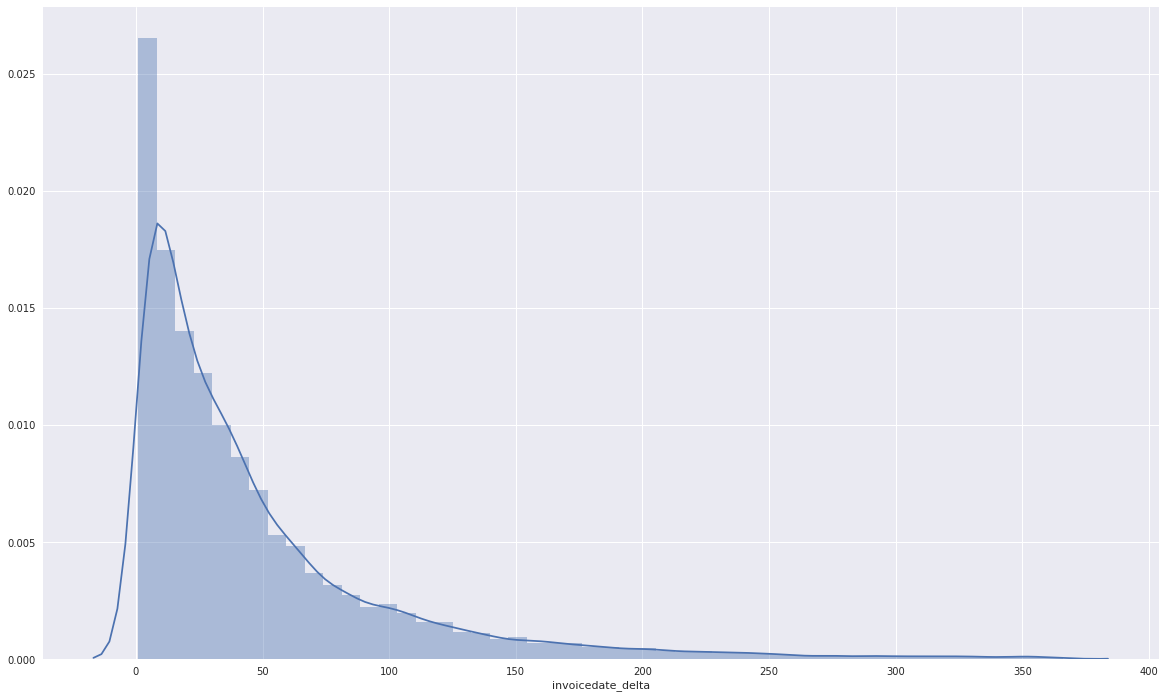

In [448]:
sns.distplot(df['invoicedate_delta'])

<a id="de_cancellation"></a>
#### Cancellation

In [424]:

query = """
    SELECT cancellation
          ,count(distinct invoiceno) AS dist_invoiceno
          ,count(distinct invoicedate::date) AS dist_invoicedate
    FROM public.online_retail_data
    GROUP BY 1
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)
df


,cancellation,dist_invoiceno,dist_invoicedate
0,1,3836,302
1,0,22062,305


In [435]:

query = """
    SELECT *
    FROM public.online_retail_data
    WHERE cancellation = 1
    LIMIT 5
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFra me(cur.fetchall(), columns=colnames)
df


,cancellation,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,1,549731,21746.0,SMALL RED RETROSPOT WINDMILL,-2.0,2011-04-11 16:36:00,1.25,13266.0,United Kingdom
1,1,549731,21399.0,BLUE POLKADOT COFFEE MUG,-48.0,2011-04-11 16:36:00,0.39,13266.0,United Kingdom
2,1,549753,22162.0,HEART GARLAND RUSTIC PADDED,-8.0,2011-04-12 11:17:00,2.95,13268.0,United Kingdom
3,1,549753,22891.0,TEA FOR ONE POLKADOT,-1.0,2011-04-12 11:17:00,4.25,13268.0,United Kingdom
4,1,549786,22345.0,PARTY PIZZA DISH BLUE POLKADOT,-18.0,2011-04-12 11:58:00,0.85,14071.0,United Kingdom


In [437]:

query = """
    SELECT *
    FROM public.online_retail_data
    WHERE invoiceno = '549731'
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)
df


,cancellation,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,1,549731,21746.0,SMALL RED RETROSPOT WINDMILL,-2.0,2011-04-11 16:36:00,1.25,13266.0,United Kingdom
1,1,549731,21399.0,BLUE POLKADOT COFFEE MUG,-48.0,2011-04-11 16:36:00,0.39,13266.0,United Kingdom
2,1,549731,21399.0,BLUE POLKADOT COFFEE MUG,-1.0,2011-04-11 16:36:00,0.39,13266.0,United Kingdom


In [ ]:
sns.distplot(df['invoicedate_delta'])

<a id="de_invoiceno"></a>
#### Invoice No

<a id="de_stockcode"></a>
#### Stockcode

<a id="de_description"></a>
#### Description

<a id="de_quantity"></a>
#### Quantity

<a id="de_invoicedate"></a>
#### Invoice Date

In [ ]:
# Average number of days betwee

<a id="de_unitprice"></a>
#### Unit Price

<a id="de_customerid"></a>
#### Customer ID

<a id="de_country"></a>
#### Country

In [16]:

query = """
    SELECT count(distinct country) As distinct_country
    FROM public.online_retail_data
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
pd.DataFrame(cur.fetchall(), columns=colnames)


,distinct_country
0,38


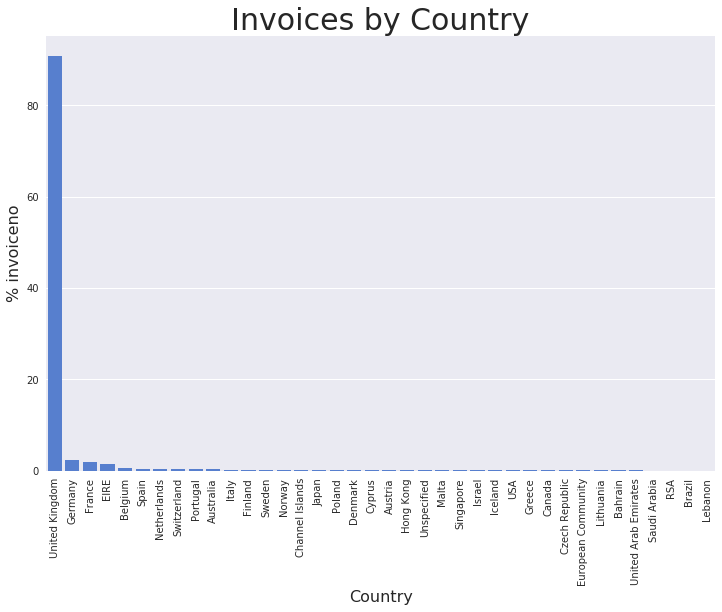

In [25]:

query = """
    SELECT country
          ,count(distinct invoiceno) AS distinct_invoiceno
          ,count(distinct customerid) AS distinct_customerid
    FROM public.online_retail_data
    GROUP BY 1
    ORDER BY 2 DESC;
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)

df['perc_invoiceno'] = (df['distinct_invoiceno'] * 100.0) / sum(df['distinct_invoiceno'])
df = df.sort_values('perc_invoiceno',ascending=False)

bar_plot(df,"Invoices by Country","country","Country","perc_invoiceno","% invoiceno", "#4378E2")

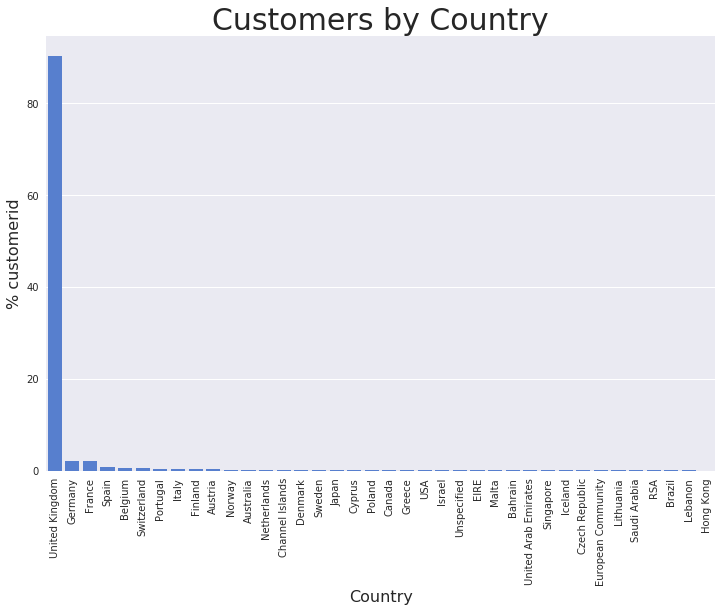

In [26]:
df['perc_customerid'] = (df['distinct_customerid'] * 100.0) / sum(df['distinct_customerid'])
df = df.sort_values('perc_customerid',ascending=False)
bar_plot(df,"Customers by Country","country","Country","perc_customerid","% customerid", "#4378E2")

----
## Feature Engineering

In [20]:
# Create list of customers to exclude - outliers
query = """
    SELECT customerid
          ,count(distinct invoiceno) AS distinct_invoiceno
    FROM public.online_retail_data
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 500;
"""
cur.execute(query)
colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)

customerIDExcludeList = df.query('distinct_invoiceno > 20')['customerid'].unique()
print """{} customerid are associated with greater than 20 invoices""".format(len(customerIDExcludeList))
customerIDExcludeList = customerIDExcludeList[customerIDExcludeList != np.array(None)]

143 customerid are associated with greater than 20 invoices


In [253]:
query = """
    DROP TABLE IF EXISTS public.model_inputs_raw
"""
cur.execute(query)

query = """
    CREATE TABLE public.model_inputs_raw AS
    SELECT CASE WHEN invoicedate_delta <= 14 THEN 1 ELSE 0 END AS trxn_next_14_days
          ,*
    FROM (
        SELECT *
              ,date_part('day', lead(invoicedate,1,null) OVER (PARTITION BY customerid ORDER BY invoicedate) - invoicedate) AS invoicedate_delta
        FROM (
            SELECT customerid
                  ,invoiceno
                  ,invoicedate
                  ,max(cancellation) AS cancellation_exists
                  ,sum(quantity) AS total_num_ind_items
                  ,count(distinct stockcode) AS total_num_unq_items
                  ,sum(quantity * unitprice) AS total_dollar_amount
                  ,min(unitprice) AS min_item_amount
                  ,max(unitprice) AS max_item_amount   
                  ,max(CASE WHEN country = 'United Kingdom' THEN 1 ELSE 0 END) AS country_uk
                  ,max(CASE WHEN country = 'Germany' THEN 1 ELSE 0 END) AS country_germany
                  ,max(CASE WHEN country = 'France' THEN 1 ELSE 0 END) AS country_france
                  ,max(CASE WHEN date_part('dow', invoicedate) = 0 THEN 1 ELSE 0 END) AS dow_0
                  ,max(CASE WHEN date_part('dow', invoicedate) = 1 THEN 1 ELSE 0 END) AS dow_1
                  ,max(CASE WHEN date_part('dow', invoicedate) = 2 THEN 1 ELSE 0 END) AS dow_2
                  ,max(CASE WHEN date_part('dow', invoicedate) = 3 THEN 1 ELSE 0 END) AS dow_3
                  ,max(CASE WHEN date_part('dow', invoicedate) = 4 THEN 1 ELSE 0 END) AS dow_4
                  ,max(CASE WHEN date_part('dow', invoicedate) = 5 THEN 1 ELSE 0 END) AS dow_5
            FROM public.online_retail_data
            WHERE invoicedate > '2011-02-05'
            AND invoicedate <= '2011-11-24'
            AND customerid NOT IN ('{excl}')
            AND customerid NOTNULL
            GROUP BY 1,2,3
        ) foo JOIN (
            SELECT l.customerid
                  ,l.invoiceno
                  ,l.invoicedate
                  ,max(r.cancellation) AS cancellation_exists_lst_days
                  ,sum(CASE WHEN r.cancellation = 1 THEN (r.quantity * r.unitprice) ELSE 0 END) AS cancellation_amount_lst_days
                  ,count(distinct r.invoiceno) AS total_invoices_lst_days
                  ,sum(r.quantity * r.unitprice) AS total_dollar_amount_lst_days
                  ,count(distinct r.stockcode) AS total_num_ind_items_lst_days
            FROM public.online_retail_data l
            JOIN public.online_retail_data r
            USING (customerid)
            WHERE l.invoicedate > r.invoicedate AND
            r.invoicedate >= l.invoicedate - interval '30 days'
            AND customerid NOT IN ('{excl}')
            AND customerid NOTNULL
            GROUP BY 1,2,3
        ) bar
        USING (customerid, invoiceno, invoicedate)
    ) foobar
    WHERE invoicedate_delta NOTNULL
    ORDER BY 1
""".format(excl="','".join(customerIDExcludeList))
cur.execute(query)

featureNames = [
     'cancellation_exists'
    ,'total_num_ind_items'
    ,'total_num_unq_items'
    ,'total_dollar_amount'
    ,'min_item_amount'
    ,'max_item_amount'
    ,'country_uk'
    ,'country_germany'
    ,'country_france'
    ,'cancellation_exists_lst_days'
    ,'cancellation_amount_lst_days'
    ,'total_invoices_lst_days'
    ,'total_dollar_amount_lst_days'
    ,'total_num_ind_items_lst_days'
    ,'dow_0'
    ,'dow_1'
    ,'dow_2'
    ,'dow_3'
    ,'dow_4'
    ,'dow_5'
]

query = """
    SELECT *
    FROM public.model_inputs_raw
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)

print len(df)
print len(df['customerid'].unique())
df.head()

3503
1057


,trxn_next_14_days,customerid,invoiceno,invoicedate,cancellation_exists,total_num_ind_items,total_num_unq_items,total_dollar_amount,min_item_amount,max_item_amount,country_uk,country_germany,country_france,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,cancellation_exists_lst_days,cancellation_amount_lst_days,total_invoices_lst_days,total_dollar_amount_lst_days,total_num_ind_items_lst_days,invoicedate_delta
0,0,18260.0,554346,2011-05-23 17:48:00,1,-3.0,3,-29.95,7.50,12.50,1,0,0,0,1,0,0,0,0,0,0.0,1,1283.91,20,27.0
1,0,18260.0,549947,2011-04-13 12:47:00,0,314.0,19,451.58,0.42,12.75,1,0,0,0,0,0,1,0,0,0,0.0,1,10426.25,34,40.0
2,0,18257.0,569359,2011-10-03 14:55:00,0,3.0,1,14.85,4.95,4.95,1,0,0,0,1,0,0,0,0,0,0.0,1,517.53,25,27.0
3,0,18257.0,557961,2011-06-24 08:40:00,0,92.0,10,214.40,1.65,12.50,1,0,0,0,0,0,0,0,1,1,-132.0,1,-132.00,2,101.0
4,0,18257.0,555268,2011-06-01 16:17:00,1,-6.0,2,-13.20,1.65,4.95,1,0,0,0,0,0,1,0,0,1,-70.8,2,644.00,18,22.0


In [242]:
res = df[['trxn_next_14_days','invoiceno']].groupby(['trxn_next_14_days']).agg(['count'])
res.columns = res.columns.get_level_values(1)
res['total'] = res['count'].sum()
res['perc'] = res['count'] * 100.0 / res['total']
res

,count,total,perc
trxn_next_14_days,,,
0,1766,3503,50.413931
1,1737,3503,49.586069


----
## Model Training

In [243]:
# split training and validation set
# we are careful not to include the same customer in both sets
query = """
    DROP TABLE IF EXISTS public.model_train
                        ,public.model_vali
                        ,public.model_train_base
                        ,public.model_vali_base;
"""
cur.execute(query)

# Training table
query ="""
    CREATE TABLE public.model_train_base AS
    SELECT customerid
    FROM (
        SELECT customerid
        FROM public.model_inputs_raw
        GROUP BY 1
    ) foo
    WHERE random() < 0.21;
"""
cur.execute(query)
#tc = cur.rowcount

query ="""
    CREATE TABLE public.model_train AS
    SELECT row_number() OVER() AS _id
          ,r.*
    FROM public.model_train_base l
    JOIN public.model_inputs_raw r
    USING (customerid);
"""
cur.execute(query)
tc = cur.rowcount

# Validation table
query ="""
    CREATE TABLE public.model_vali_base AS
    SELECT l.customerid
    FROM public.model_inputs_raw l
    LEFT JOIN public.model_train_base r
    USING (customerid)
    WHERE r.customerid ISNULL
    GROUP BY 1;
"""
cur.execute(query)
#vc = cur.rowcount

query ="""
    CREATE TABLE public.model_vali AS
    SELECT row_number() OVER() AS _id
          ,r.*
    FROM public.model_vali_base l
    JOIN public.model_inputs_raw r
    USING (customerid);
"""
cur.execute(query)
vc = cur.rowcount

# clean up
query = """
    DROP TABLE IF EXISTS public.model_train_base, public.model_vali_base;
"""
cur.execute(query)

# print train/vali balance
printmd("**Training / Validation Balance:**")
print "Train: {} ({}%)".format(tc, round((tc * 100.0 / (tc + vc)),2))
print "Vali:  {} ({}%)".format(vc, round((vc * 100.0 / (tc + vc)),2))

**Training / Validation Balance:**

Train: 2268 (64.74%)
Vali:  1235 (35.26%)


In [244]:
query = """
    SELECT *
    FROM public.model_train
    LIMIT 5
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)
df

,_id,trxn_next_14_days,customerid,invoiceno,invoicedate,cancellation_exists,total_num_ind_items,total_num_unq_items,total_dollar_amount,min_item_amount,max_item_amount,country_uk,country_germany,country_france,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,cancellation_exists_lst_days,cancellation_amount_lst_days,total_invoices_lst_days,total_dollar_amount_lst_days,total_num_ind_items_lst_days,invoicedate_delta
0,1,0,15271.0,565674,2011-09-06 09:49:00,0,74.0,13,224.28,0.85,12.50,1,0,0,0,0,1,0,0,0,0,0.0,1,1843.14,35,48.0
1,3,0,15271.0,558480,2011-06-30 08:17:00,0,63.0,9,145.75,1.25,9.95,1,0,0,0,0,0,0,1,0,0,0.0,1,1575.81,11,46.0
2,5,0,15271.0,553895,2011-05-19 17:18:00,0,70.0,7,116.50,0.85,4.15,1,0,0,0,0,0,0,1,0,0,0.0,1,746.62,6,23.0
3,7,0,15260.0,555628,2011-06-06 11:59:00,0,148.0,16,387.88,0.42,15.95,1,0,0,0,1,0,0,0,0,0,0.0,1,3110.40,9,45.0
4,9,0,13743.0,564228,2011-08-24 10:20:00,0,264.0,4,116.88,0.29,1.45,1,0,0,0,0,0,1,0,0,0,0.0,1,665.28,6,19.0


In [245]:
featureNames

['cancellation_exists',
 'total_num_ind_items',
 'total_num_unq_items',
 'total_dollar_amount',
 'min_item_amount',
 'max_item_amount',
 'country_uk',
 'country_germany',
 'country_france',
 'cancellation_exists_lst_days',
 'cancellation_amount_lst_days',
 'total_invoices_lst_days',
 'total_dollar_amount_lst_days',
 'total_num_ind_items_lst_days',
 'dow_0',
 'dow_1',
 'dow_2',
 'dow_3',
 'dow_4',
 'dow_5']

In [246]:
# traing random forest model
query = """
DROP TABLE IF EXISTS public.rf_model_output, public.rf_model_output_summary, public.rf_model_output_group;
SELECT madlib.forest_train(
            'public.model_train',
            'public.rf_model_output',
            '_id',
            'trxn_next_14_days',
            '{}',
            null,
            null,
            30::integer,
            4::integer,
            true::boolean,
            1::integer,
            8::integer,
            3::integer,
            1::integer,
            10::integer
        )
""".format(','.join(featureNames))
cur.execute(query)

In [247]:
# view model summary
query = """
    SELECT *
    FROM public.rf_model_output_summary
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)
df

,method,is_classification,source_table,model_table,id_col_name,dependent_varname,independent_varnames,cat_features,con_features,grouping_cols,num_trees,num_random_features,max_tree_depth,min_split,min_bucket,num_splits,verbose,importance,num_permutations,num_all_groups,num_failed_groups,total_rows_processed,total_rows_skipped,dependent_var_levels,dependent_var_type,independent_var_types,null_proxy
0,forest_train,True,public.model_train,public.rf_model_output,_id,trxn_next_14_days,"cancellation_exists,total_num_unq_items,country_uk,country_germany,country_france,cancellation_exists_lst_days,total_invoices_lst_days,total_num_ind_items_lst_days,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,total_num_ind_items,total_dollar_amount,min_item_amount,max_item_amount,cancellation_amount_lst_days,total_dollar_amount_lst_days","cancellation_exists,total_num_unq_items,country_uk,country_germany,country_france,cancellation_exists_lst_days,total_invoices_lst_days,total_num_ind_items_lst_days,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5","total_num_ind_items,total_dollar_amount,min_item_amount,max_item_amount,cancellation_amount_lst_days,total_dollar_amount_lst_days",None,30,4,8,3,1,10,False,True,1,1,0,2268,0,"""0"",""1""",integer,"integer, bigint, integer, integer, integer, integer, bigint, bigint, integer, integer, integer, integer, integer, integer, double precision, double precision, double precision, double precision, double precision, double precision",None


In [248]:
# variable importance
query = """
    SELECT 'cat' AS type
          ,unnest(string_to_array(cat_features,',')) AS feature_name
          ,unnest(cat_var_importance) AS feature_importance
    FROM public.rf_model_output_group l
        ,public.rf_model_output_summary r
    UNION
    SELECT 'con' AS type
          ,unnest(string_to_array(con_features,',')) AS feature_name
          ,unnest(con_var_importance) AS feature_importance
    FROM public.rf_model_output_group l
        ,public.rf_model_output_summary r
    ORDER BY 3
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)

printmd("-----\n **Variable Importance:**")
df

-----
 **Variable Importance:**

,type,feature_name,feature_importance
0,cat,cancellation_exists,-0.209729
1,cat,total_invoices_lst_days,-0.209224
2,cat,cancellation_exists_lst_days,-0.208589
3,con,total_dollar_amount_lst_days,-0.207852
4,con,min_item_amount,-0.207831
5,con,total_dollar_amount,-0.207628
6,con,cancellation_amount_lst_days,-0.205519
7,con,total_num_ind_items,-0.205019
8,cat,total_num_unq_items,-0.204925
9,cat,total_num_ind_items_lst_days,-0.204525


In [249]:
# Score out-of-sample
query = """
    DROP TABLE IF EXISTS public.model_vali_scored;
    SELECT madlib.forest_predict('public.rf_model_output',
                                 'public.model_vali',
                                 'public.model_vali_scored',
                                 'prob');
                
    DROP TABLE IF EXISTS public.model_vali_scored_tmp;
    CREATE TABLE public.model_vali_scored_tmp AS
    SELECT *
    FROM public.model_vali_scored
    JOIN public.model_vali
    USING (_id);
    DROP TABLE public.model_vali_scored;
    ALTER TABLE public.model_vali_scored_tmp RENAME TO model_vali_scored;
    SELECT * FROM public.model_vali_scored LIMIT 0;
    
"""
cur.execute(query)

In [250]:
# auc
query = """
    DROP TABLE IF EXISTS public.model_vali_scored_auc;
    SELECT madlib.area_under_roc(
        'public.model_vali_scored'
       ,'public.model_vali_scored_auc'
       ,'estimated_prob_1'
       ,'trxn_next_14_days'
    )
"""
cur.execute(query)

query = """
    SELECT * 
    FROM public.model_vali_scored_auc;
"""
cur.execute(query)
colnames = [desc[0] for desc in cur.description]
auc = (pd.DataFrame(cur.fetchall(), columns=colnames))['area_under_roc'][0]

message = """-----\n **AUC =** {:0.5f}""".format(auc)
printmd(message)

message = """
**Previous Iterations:**
1. AUC = 0.52446 <- Init model
2. AUC = 0.58271 <- Add 3 historical variables
3. AUC = 0.54065 <- Changed forecast window to 30 days
4. AUC = 
5. 

"""
printmd(message)

-----
 **AUC =** 0.56154


**Previous Iterations:**
1. AUC = 0.52446 <- Init model
2. AUC = 0.58271 <- Add 3 historical variables
3. AUC = 0.54065 <- Changed forecast window to 30 days
4. AUC = 
5. 



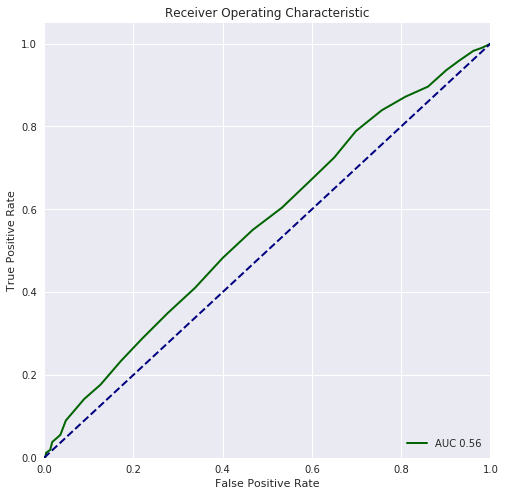

In [251]:
# roc
query = """
    DROP TABLE IF EXISTS public.model_vali_scored_roc;
    SELECT madlib.binary_classifier( 
        'public.model_vali_scored'
       ,'public.model_vali_scored_roc'
       ,'estimated_prob_1'
       ,'trxn_next_14_days'
    );
"""
cur.execute(query)

query = """
    SELECT * 
    FROM public.model_vali_scored_roc
    ORDER BY 1
"""
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
df = pd.DataFrame(cur.fetchall(), columns=colnames)

# roc curve
pylab.rcParams['figure.figsize'] = (8, 8)

plt.figure()
lw = 2
plt.plot(df['fpr'], df['tpr'], color='darkgreen', lw=lw, label='AUC {:0.2f}'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [252]:
# confusion matrix (inclusive)
cutoff = 0.5

query = """
    SELECT trxn_next_14_days AS obs
          ,CASE WHEN estimated_prob_1 >= {} THEN 1 ELSE 0 END AS pred
          ,count(*) AS num
    FROM public.model_vali_scored
    GROUP BY 1,2
    ORDER BY 1,2
""".format(cutoff)
cur.execute(query)

colnames = [desc[0] for desc in cur.description]
pd.DataFrame(cur.fetchall(), columns=colnames)


,obs,pred,num
0,0,0,435
1,0,1,222
2,1,0,341
3,1,1,237
